# Python project: wine review based on NLP

Can we predict if a wine is good or not, according to a description of it?

In [17]:
#Import needed libraries
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from nltk.stem.porter import PorterStemmer
import seaborn as sns
import re
import nltk
import wordcloud
from textblob import TextBlob
import langdetect
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer

### Data Import

Get the data on kaggle : https://www.kaggle.com/zynicide/wine-reviews/
Then import it, there are 2 files, so i use glob to concatenate them
This data contains reviews about wine. Each line corresponds to a wine, we have information about the wine in itself: country, price in U.S dollars, decription... And about the review : taster name, grade over 100 (points)...
There is about 280k rows

In [50]:
df = pd.concat(map(pd.read_csv, glob.glob('wineData/*.csv')), sort = False, ignore_index=True)
i = range(200000)
df.drop(i) 
#Jupyter is a bit low to run code so i decide to remove a bit of data
#But i treat the complete data with spyder and there is no signifant change on results
df.head() #First look on our data

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


### Data cleaning

In [51]:
#First, there was already an id column in the dataset, so we can erase it
df = df.drop('Unnamed: 0', axis=1)

In [52]:
#Let's see the na percentage on every column
def null_percent():
    percent_missing = df.isnull().sum() * 100 / len(df)
    return percent_missing
null_percent()

country                   0.024208
description               0.000000
designation              29.618976
points                    0.000000
price                     8.077935
province                  0.024208
region_1                 16.485167
region_2                 60.319116
taster_name              63.073467
taster_twitter_handle    64.842418
title                    53.730674
variety                   0.000356
winery                    0.000000
dtype: float64

region_2 has 60% percent NA and is not an interesting factor for us, so we can erase this column too.
For others missing values for string type colums we can replace NA by 'Unknown', so we do this for: country, designation, province, region_1, variety.

In [53]:
df = df.drop('region_2', axis=1)
df[['designation', 'region_1', 'country', 'province', 'variety']] = df[['designation', 'region_1', 'country', 'province', 'variety']].fillna('Unknown')

About these columns : taster_name and taster_twitter_handle. Do we have in the dataset a twitter's taster if we have not the name of the taster? 

In [54]:
#Look for NA taster_name that have a twitter
only_twitter = df.loc[df['taster_name'].isnull() & df['taster_twitter_handle'].notna(), ['taster_name', 'taster_twitter_handle']]
num_only_twitter = len(only_twitter.index)
num_only_twitter

0

In [55]:
#so there is none NA taster with a known twitter, thus the twitter column give us no information, we can delete it
df = df.drop('taster_twitter_handle', axis=1)
#and fill NA tasters by 'unknown'
df['taster_name'] = df['taster_name'].fillna('Unknown')

#now we can look the title column
#i realise that this column was not present in the first csv file but present in the second
#i will not use this column so i can delete it, otherwise i would have delete the first csv
df = df.drop('title', axis=1)

#Last column with NA is the price, i decided to change NA price to the mean price to keep data coherence
df['price'] = df['price'].fillna(df['price'].mean())

#let's check null percent again
null_percent()

country        0.0
description    0.0
designation    0.0
points         0.0
price          0.0
province       0.0
region_1       0.0
taster_name    0.0
variety        0.0
winery         0.0
dtype: float64

This time we are good!

### Dataviz

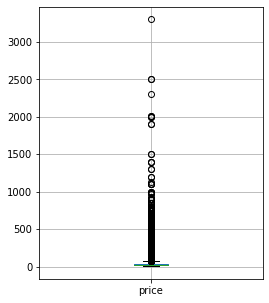

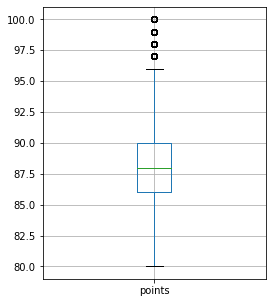

In [20]:
#we can have a look on price and points by printing boxplots
#we could also see if there is aberrant values
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(4, 5))
df.boxplot(column='price', ax=ax1)

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(4, 5))
df.boxplot(column='points', ax=ax1)

We notice that majority of prices are compressed at the bottom, making the boxplot unreadable. There is no negative price which is a good point. Some prices are really high, greater than 3000$ but we are talking about wine, so it might be coherent. Now about points, wines are graded over 100, we can't see wines with negative or greater than 100 grades, so no aberrant values. We also notice all notes are greater than 80 whereas grades are over 100

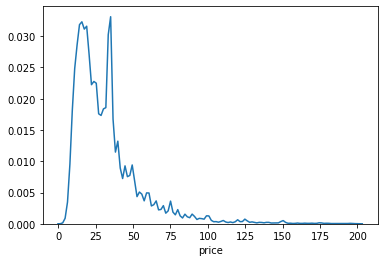

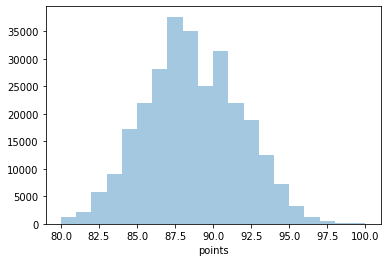

In [21]:
#other plots to better visualize price and points
distrib = pd.Series(df.loc[df["price"]<200]["price"], name="price")
sns.distplot(distrib, hist = False)

plt.figure()
distribPoints = pd.Series(df.loc[df["points"]>=80].points, name="points")
sns.distplot(distribPoints, bins = 20, kde = False)

About price, we can see better that a huge majority of prices are under 100$. Points distribution looks like a normal distribution which can be interesting since we want to know if a wine is tasty.

For our first model we will simplify points by splitting it into two categories: 0 for wine under 88 (bad wines), 1 for wines above (good wines). 88 is approximatively the median.

In [8]:
def cat_points(points):
    if points in list(range(80,88)):
        return 0
    else:
        return 1

df["rating_cat"] = df["points"].apply(cat_points)


In [9]:
#Check if all descriptions are in english
df['lang'] = df["description"].apply(lambda x: langdetect.detect(x) if 
                                 x.strip() != "" else "")
df.head()

,country,description,designation,points,price,province,region_1,taster_name,variety,winery,rating_cat,lang
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,34.177162,Sicily & Sardinia,Etna,Kerin O’Keefe,White Blend,Nicosia,0,en
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.000000,Douro,Unknown,Roger Voss,Portuguese Red,Quinta dos Avidagos,0,en
2,US,"Tart and snappy, the flavors of lime flesh and...",Unknown,87,14.000000,Oregon,Willamette Valley,Paul Gregutt,Pinot Gris,Rainstorm,0,en
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.000000,Michigan,Lake Michigan Shore,Alexander Peartree,Riesling,St. Julian,0,en
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.000000,Oregon,Willamette Valley,Paul Gregutt,Pinot Noir,Sweet Cheeks,0,en


In [10]:
df.loc[df['lang']!='en'].count()[0]

12

Only 12 decriptions are detected as non english, they would not of a big impact on our study. 

Now let's make our data exploitable. So we use lemmatization to regroup same family name, for example "send" and "sent". We tokenize the text, remove stop words such as "and". We save these clear descriptions in the text_clean column of our dataframe.

In [9]:
def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text
lst_stopwords = nltk.corpus.stopwords.words("english")
df["text_clean"] = df["description"].apply(lambda x: utils_preprocess_text(x, False, True, lst_stopwords))

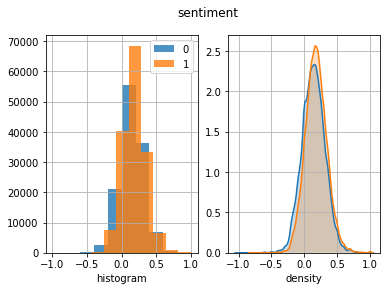

In [12]:
# do sentiment analysis to find features for creating our model
df["sentiment"] = df["description"].apply(lambda x: 
                   TextBlob(x).sentiment.polarity)
x, y = "sentiment", "rating_cat"
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.suptitle(x, fontsize=12)
for i in df[y].unique():
    sns.distplot(df[df[y]==i][x], hist=True, kde=False, 
                 bins=10, hist_kws={"alpha":0.8}, 
                 axlabel="histogram", ax=ax[0])
    sns.distplot(df[df[y]==i][x], hist=False, kde=True, 
                 kde_kws={"shade":True}, axlabel="density",   
                 ax=ax[1])
ax[0].grid(True)
ax[0].legend(df[y].unique())
ax[1].grid(True)
plt.show()

In our case we can't do nothing about sentiment analysis, ditributions are way too close

[Text(0, 0.5, '')]

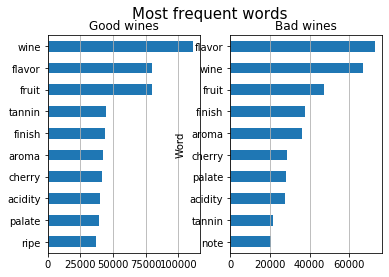

In [13]:
# Let's try to find other exploitable feature
# We look 10 more recurrent words for each rating categories of wine
rate = 1
corpus = df[df[y]==rate]["text_clean"]
lst_tokens = nltk.tokenize.word_tokenize(corpus.str.cat(sep=" "))
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.suptitle("Most frequent words", fontsize=15)
    
dic_words_freq = nltk.FreqDist(lst_tokens)
df_uni = pd.DataFrame(dic_words_freq.most_common(), 
                       columns=["Word","Freq"])
df_uni.set_index("Word").iloc[:10,:].sort_values(by="Freq").plot(
                  kind="barh", title="Good wines", ax=ax[0], 
                  legend=False).grid(axis='x')
ax[0].set(ylabel=None)

rate = 0
corpus = df[df[y]==rate]["text_clean"]
lst_tokens = nltk.tokenize.word_tokenize(corpus.str.cat(sep=" "))
dic_words_freq = nltk.FreqDist(lst_tokens)
df_uni = pd.DataFrame(dic_words_freq.most_common(), 
                       columns=["Word","Freq"])
df_uni.set_index("Word").iloc[:10,:].sort_values(by="Freq").plot(
                  kind="barh", title="Bad wines", ax=ax[1], 
                  legend=False).grid(axis='x')
ax[0].set(ylabel=None)


So here more recurrent words are the same for both categories, so we are blocked here too. We can try with pair of more recurrent words.

[Text(0, 0.5, '')]

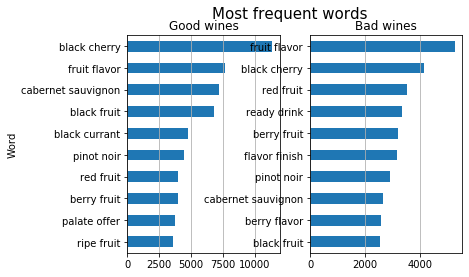

In [14]:
rate = 1
corpus = df[df[y]==rate]["text_clean"]
lst_tokens = nltk.tokenize.word_tokenize(corpus.str.cat(sep=" "))
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.suptitle("Most frequent words", fontsize=15)
dic_words_freq = nltk.FreqDist(nltk.ngrams(lst_tokens, 2))
df_bi = pd.DataFrame(dic_words_freq.most_common(), 
                      columns=["Word","Freq"])
df_bi["Word"] = df_bi["Word"].apply(lambda x: " ".join(
                   string for string in x) )
df_bi.set_index("Word").iloc[:10,:].sort_values(by="Freq").plot(
                  kind="barh", title="Good wines", ax=ax[0],
                  legend=False).grid(axis='x')
ax[1].set(ylabel=None)


rate = 0
corpus = df[df[y]==rate]["text_clean"]
lst_tokens = nltk.tokenize.word_tokenize(corpus.str.cat(sep=" "))


dic_words_freq = nltk.FreqDist(nltk.ngrams(lst_tokens, 2))
dtf_bi = pd.DataFrame(dic_words_freq.most_common(), 
                      columns=["Word","Freq"])
dtf_bi["Word"] = dtf_bi["Word"].apply(lambda x: " ".join(
                   string for string in x) )
dtf_bi.set_index("Word").iloc[:10,:].sort_values(by="Freq").plot(
                  kind="barh", title="Bad wines", ax=ax[1],
                  legend=False).grid(axis='x')
ax[1].set(ylabel=None)

Here also, it's impossible to do conclusions with pair of words.

Let's look at something different and consider legnth analysis. For each description we are gonna create five information: number of words, number of chars, number of sentences, average number of char per word, average number of word per sentence.

In [13]:
df['word_count'] = df["description"].apply(lambda x: len(str(x).split(" ")))
df['char_count'] = df["description"].apply(lambda x: sum(len(word) for word in str(x).split(" ")))
df['sentence_count'] = df["description"].apply(lambda x: len(str(x).split(".")))
df['avg_word_length'] = df['char_count'] / df['word_count']
df['avg_sentence_lenght'] = df['word_count'] / df['sentence_count']

def graph(x):
    y="rating_cat"
    fig, ax = plt.subplots(nrows=1, ncols=2)
    fig.suptitle(x, fontsize=12)
    for i in df[y].unique():
        sns.distplot(df[df[y]==i][x], hist=True, kde=False, 
                 bins=10, hist_kws={"alpha":0.8}, 
                 axlabel="histogram", ax=ax[0])
        sns.distplot(df[df[y]==i][x], hist=False, kde=True, 
                 kde_kws={"shade":True}, axlabel="density",   
                 ax=ax[1])
    ax[0].grid(True)
    ax[0].legend(df[y].unique())
    ax[1].grid(True)
    plt.show()

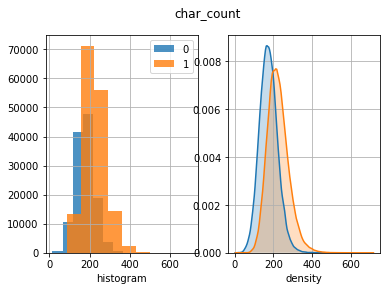

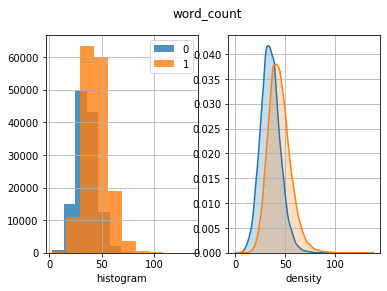

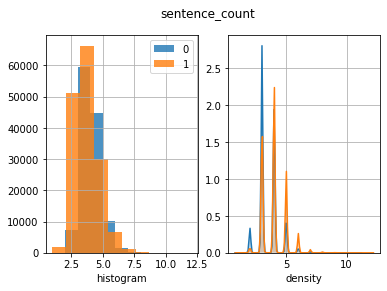

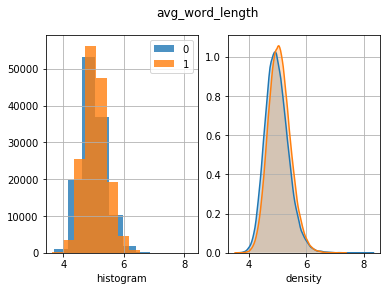

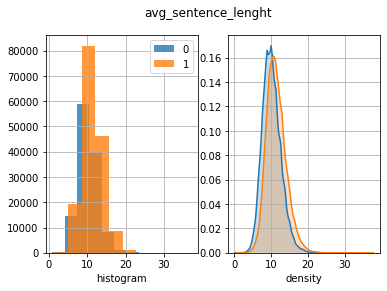

In [16]:
graph('char_count')
graph('word_count')
graph('sentence_count')
graph('avg_word_length')
graph('avg_sentence_lenght')

For sentence_count, avg_word_length, avg_sentence_length we have quite bad results, distributions are really close. For word_count and char_count it's a bit better. So we can try a first model with word_count, it's the best we have for the moment. 

### Model

In [14]:
#logistic regression
features=np.array(df["word_count"]).reshape(-1,1)
labels = df["rating_cat"]
#split testing and trainig set
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size = .25, random_state = 1)
lr = LogisticRegression(solver='lbfgs')
lr.fit(features_train, labels_train)
#we print score of regresion
print(lr.score(features_test, labels_test))
y_pred=lr.predict(features_test)
#compute confusion matrix
confusion_matrix = pd.crosstab(np.array(labels_test), np.array(y_pred), rownames=['Actual'], colnames=['Predicted'])
print(confusion_matrix)

0.6727280494403782
Predicted      0      1
Actual                 
0          17483  13315
1           9668  29760


As expected this model is not really good, with an accuracy of 67%. Now we try with TF-IDF which is more powerful.

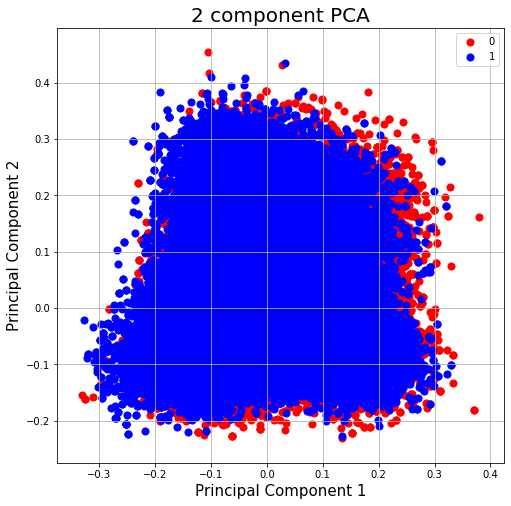

In [15]:
# we apply tf-idf on our data
features = df['text_clean']
tv = TfidfVectorizer(max_features = 5000)
features = list(features)
features = tv.fit_transform(features).toarray()

# we do PCA to visualize an idea of this new feature
x = features
y = df.loc[:,['rating_cat']].values
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
finalDf = pd.concat([principalDf, df['rating_cat'].reset_index()], axis = 1)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
rates = [0,1]
colors = ['r', 'b']
for rate, color in zip(rates,colors):
    indicesToKeep = finalDf['rating_cat'] == rate
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(rates)
ax.grid()

So it seems difficult to differenciate good wines from bad wines on this plot. We can hope it's because of the PCA, which could give not relevant components. So we try another logistic regression based on the result of TF-IDF. 

In [16]:
# getting training and testing data
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size = .25, random_state = 1)
lr = LogisticRegression(solver='lbfgs', max_iter = 2000)
lr.fit(features_train, labels_train)
print("score : ",lr.score(features_test, labels_test))
#compute confusion matrix
confusion_matrix = pd.crosstab(np.array(labels_test), np.array(y_pred), rownames=['Actual'], colnames=['Predicted'])
print(confusion_matrix)

score :  0.8388346196565375
Predicted      0      1
Actual                 
0          17483  13315
1           9668  29760


So this model with TF-IDF is better than previous one (84% of accuracy instead of 67%), there are still progress to do. We can see that we have a lot of false positive. Maybe we can find a bias to apply to our model to improve it on this point. Now let's visualize what words our model look to take decisions.

In [48]:
tv.get_feature_names()
word_importance = []
for i in range(len(lr.coef_[0])):
    word_importance.append([tv.get_feature_names()[i], lr.coef_[0][i]])

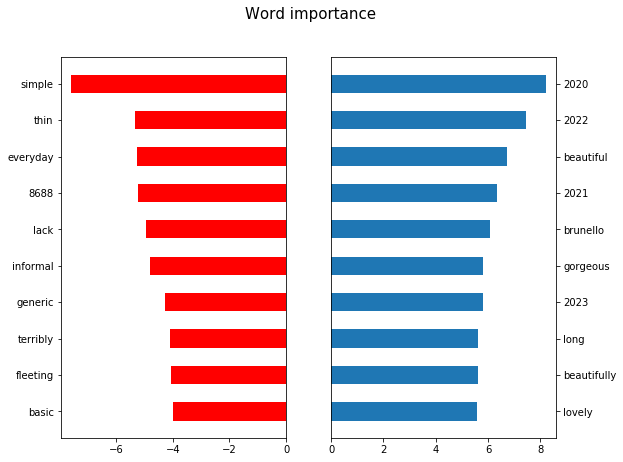

In [49]:
top = sorted(range(len(word_importance)), key=lambda i: word_importance[i][1])[-10:]

low = sorted(range(len(word_importance)), key = lambda i: word_importance[i][1])[:10]

bad_wine_words = []
bad_wine_values = []
for i in low:
    bad_wine_words.append(word_importance[i][0])
    bad_wine_values.append(word_importance[i][1])
   
good_wine_words = []
good_wine_values = []
for i in top:
    good_wine_words.append(word_importance[i][0])
    good_wine_values.append(word_importance[i][1])

fig, ax1 = plt.subplots(ncols=2, figsize=[9, 7])
fig.suptitle("Word importance", fontsize=15)
ax1 = ax1.flatten()
fig.subplots_adjust(left=0.115, right=0.88)
pos = np.arange(len(good_wine_words))
rects = ax1[1].barh(good_wine_words, good_wine_values,
                    align='center',
                    height=0.5)
rects = ax1[0].barh(bad_wine_words[::-1], bad_wine_values[::-1],
                    align='center',
                    height=0.5, color='r')
ax1[1].yaxis.set_label_position("right")
ax1[1].yaxis.tick_right()

Our classifier correctly picks up on some patterns (simple, lack, beautiful...), but clearly seems to be overfitting on some meaningless terms (8688, 2022, 2023...). We can also notice a stemming problem on words beautiful/beautifully.
We may improve our classification by cleaning our data on these points or we could use another method as word2vec for example and hope a better result.
Our results, while not perfect, shows that it's possible to predict if a wine is good or not with a description of it.

In [1]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import importlib, pkg_resources, tokenizers
importlib.reload(pkg_resources)
importlib.reload(tokenizers)
import torch
import glob
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
df = pd.concat(map(pd.read_csv, glob.glob('wineData/*.csv')), sort = False, ignore_index=True)
#df.head()

In [3]:
df = df.drop(['Unnamed: 0', "country", "designation", "price", "province", "region_1", "region_2", "taster_name",
             "taster_twitter_handle", "title", "variety", "winery"], axis=1)
def cat_points(points):
    if points in list(range(80,88)):
        return 0
    else:
        return 1

df["rating_cat"] = df["points"].apply(cat_points)
class_names = [0,1]
df.head()

,description,points,rating_cat
0,"Aromas include tropical fruit, broom, brimston...",87,0
1,"This is ripe and fruity, a wine that is smooth...",87,0
2,"Tart and snappy, the flavors of lime flesh and...",87,0
3,"Pineapple rind, lemon pith and orange blossom ...",87,0
4,"Much like the regular bottling from 2012, this...",87,0


In [4]:
pdf = df.to_pickle("./wine.pkl")
unpickled_df = pd.read_pickle("./wine.pkl")

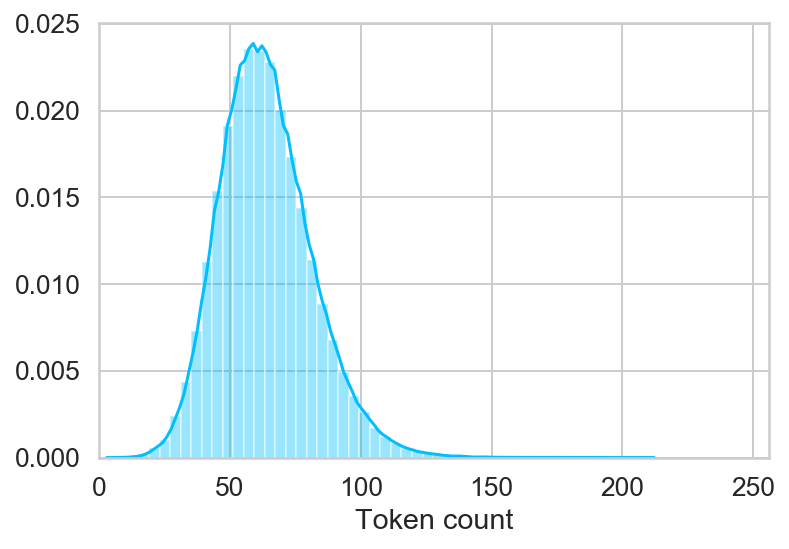

In [5]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
token_lens = []
for txt in df['description']:
  tokens = tokenizer.encode(txt, max_length=512, truncation=True)
  token_lens.append(len(tokens))
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

In [6]:
MAX_LEN = 160
class GPReviewDataset(Dataset):
  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  def __len__(self):
    return len(self.reviews)
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]
    
    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
      truncation = True
    )
    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [7]:
df_train, df_test = train_test_split(
  df,
  test_size=0.1,
  random_state=RANDOM_SEED
)
df_val, df_test = train_test_split(
  df_test,
  test_size=0.5,
  random_state=RANDOM_SEED
)
df_train.shape, df_val.shape, df_test.shape


((252810, 3), (14045, 3), (14046, 3))

In [8]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df['description'].to_numpy(),
    targets=df['rating_cat'].to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )
  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=0
  )
if __name__ == "__main__":
    BATCH_SIZE = 16
    train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
    val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
    test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [9]:
print(train_data_loader)
data = next(iter(train_data_loader))
data.keys()
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 160])
torch.Size([16, 160])
torch.Size([16])


In [10]:
class SentimentClassifier(nn.Module):
  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [11]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

In [12]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
print(type(input_ids))
print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

<class 'torch.Tensor'>
torch.Size([16, 160])
torch.Size([16, 160])


In [13]:
model(input_ids, attention_mask)

tensor([[ 0.5021, -0.1551],
        [ 0.5774, -0.4938],
        [ 0.2241, -0.5211],
        [-0.2359, -0.3053],
        [ 0.0855,  0.1286],
        [ 0.1598, -0.6331],
        [-0.1721, -0.2931],
        [ 0.4131, -0.3000],
        [ 0.5554, -0.9242],
        [ 0.3706,  0.1177],
        [-0.0914, -0.8306],
        [-0.0578, -0.5139],
        [ 0.1872, -0.3566],
        [ 0.0741, -0.3565],
        [ 0.3724, -0.0951],
        [-0.0478, -0.6130]], grad_fn=<AddmmBackward>)

In [14]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.7597, 0.2403],
        [0.4279, 0.5721],
        [0.7546, 0.2454],
        [0.5266, 0.4734],
        [0.6141, 0.3859],
        [0.5252, 0.4748],
        [0.6147, 0.3853],
        [0.7161, 0.2839],
        [0.7405, 0.2595],
        [0.7359, 0.2641],
        [0.7939, 0.2061],
        [0.6441, 0.3559],
        [0.7500, 0.2500],
        [0.6414, 0.3586],
        [0.6317, 0.3683],
        [0.5821, 0.4179]], grad_fn=<SoftmaxBackward>)

In [15]:
EPOCHS = 10
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

In [16]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()
  losses = []
  correct_predictions = 0
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)
    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask,
      #return_dict=False
    )
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)
    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
  return correct_predictions.double() / n_examples, np.mean(losses)

In [17]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
    
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)
      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
%%time
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)
  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )
  print(f'Train loss {train_loss} accuracy {train_acc}')
  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )
  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()
  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)
  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc


Epoch 1/10
----------
